## Лабораторна робота №4
з дисципліни "Нейронні мережі"
  
студента групи АнД-41
  
Бережного Дмитра

### Варіант № 2

## Завдання

1. Виконати вирішення задачs класифікації для 3 класів з набору даних food101.

2. Індекси класів визначити індивідуально за залежностями: i1=n-1,i2=n+29,i3=n+59 (де і1,і2,і3 - індекс класу (починаючи з 0) у відсортованому за алфавітом наборі даних, n - номер за списком групи.

3. Результати оформити у вигляді файлу з кодом для моделювання та візуалізації у форматі .ipynb.

4. Результати викласти у репозиторії GitHub (папка Lab4). 

5. Підготуватися до захисту лабораторрної роботи (пояснення коду, відповіді на запитання за темою).

#### Індекси за варіантом: 1,31,61

In [205]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imread, imshow, subplots, show
import random
import os
import time
import pathlib
import pandas as pd
import numpy as np
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D,Flatten,Dense,BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adam

In [206]:
for dirpath, dirnames, filenames in os.walk("101_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 3 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 76 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 75 images in '101_food_classes_10_percent\test\deviled_eggs'.
There are 0 directories and 75 images in '101_food_classes_10_percent\test\lobster_bisque'.
There are 3 directories and 0 images in '101_food_classes_10_percent\train'.
There are 0 directories and 250 images in '101_food_classes_10_percent\train\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\train\deviled_eggs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\train\lobster_bisque'.


### Виведемо назви класів

In [207]:
data_dir = pathlib.Path("101_food_classes_10_percent/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['apple_pie' 'deviled_eggs' 'lobster_bisque']


### Отже, будемо працювати з такими стравами: яблучний пиріг,  варені яйця, біск з лобстера.

### Виведемо випадкову картинку з  тренувального датасету кожного класу

In [208]:
def view_random_image(target_dir, target_class):
    # Setup target directory (we'll view images from here)
    target_folder = target_dir+target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}") # show the shape of the image

    return img

Image shape: (394, 512, 3)


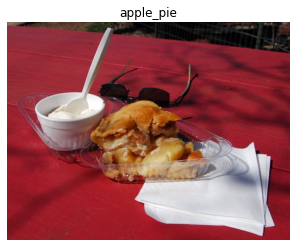

In [209]:
# View a random image from the training dataset
img = view_random_image(target_dir="101_food_classes_10_percent/train/",
                        target_class="apple_pie")

Image shape: (512, 512, 3)


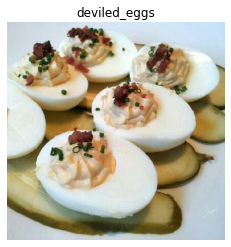

In [210]:
img = view_random_image(target_dir="101_food_classes_10_percent/train/",
                        target_class="deviled_eggs")

Image shape: (382, 512, 3)


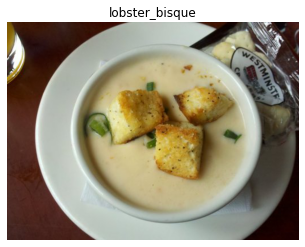

In [211]:
img = view_random_image(target_dir="101_food_classes_10_percent/train/",
                        target_class="lobster_bisque")

# 1) Тренування першої моделі

### 1.1 Без нормалізації

In [212]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Setup the train and test directories
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="categorical", # type of problem we're working on
                                               seed=42)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

Found 750 images belonging to 3 classes.
Found 225 images belonging to 3 classes.


In [213]:
train_data[10]

(array([[[[200., 110., 102.],
          [197., 104.,  96.],
          [204., 107.,  98.],
          ...,
          [220., 167.,  71.],
          [205., 139.,  52.],
          [194., 116.,  41.]],
 
         [[200., 109., 104.],
          [201., 108., 101.],
          [198., 104.,  96.],
          ...,
          [245., 209., 112.],
          [247., 199.,  99.],
          [238., 180.,  83.]],
 
         [[197., 106., 103.],
          [200., 106., 104.],
          [200., 102.,  99.],
          ...,
          [251., 232., 140.],
          [255., 227., 123.],
          [244., 208.,  96.]],
 
         ...,
 
         [[199.,  29.,   3.],
          [198.,  28.,   2.],
          [198.,  28.,   2.],
          ...,
          [216.,  78.,   3.],
          [214.,  73.,   2.],
          [222.,  79.,  11.]],
 
         [[201.,  31.,   5.],
          [199.,  29.,   3.],
          [198.,  28.,   2.],
          ...,
          [214.,  73.,   1.],
          [225.,  82.,  14.],
          [216.,  71.,   6.

In [214]:
tf.random.set_seed(42)
model_1 = tf.keras.models.Sequential([
  Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(pool_size=2,  padding="valid"), # padding can also be 'same'
  Conv2D(10, 3, activation="relu"),
  Conv2D(10, 3, activation="relu"), 
  MaxPool2D(2),
  Flatten(),
  Dense(3, activation="softmax")])

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


# Fit the model
history_1 = model_1.fit(train_data,epochs=10,validation_data=test_data)

Epoch 1/10
24/24 [==============================] - 7s 257ms/step - loss: 17.0606 - accuracy: 0.3853 - val_loss: 1.5948 - val_accuracy: 0.3956
Epoch 2/10
24/24 [==============================] - 6s 240ms/step - loss: 1.0633 - accuracy: 0.4747 - val_loss: 1.2669 - val_accuracy: 0.3822
Epoch 3/10
24/24 [==============================] - 6s 252ms/step - loss: 0.7864 - accuracy: 0.6280 - val_loss: 1.2930 - val_accuracy: 0.4400
Epoch 4/10
24/24 [==============================] - 6s 240ms/step - loss: 0.5200 - accuracy: 0.7960 - val_loss: 1.5186 - val_accuracy: 0.4400
Epoch 5/10
24/24 [==============================] - 6s 240ms/step - loss: 0.3288 - accuracy: 0.8920 - val_loss: 1.6926 - val_accuracy: 0.4489
Epoch 6/10
24/24 [==============================] - 6s 253ms/step - loss: 0.1988 - accuracy: 0.9507 - val_loss: 2.0937 - val_accuracy: 0.4222
Epoch 7/10
24/24 [==============================] - 6s 242ms/step - loss: 0.1159 - accuracy: 0.9760 - val_loss: 2.2339 - val_accuracy: 0.4133
Epoch

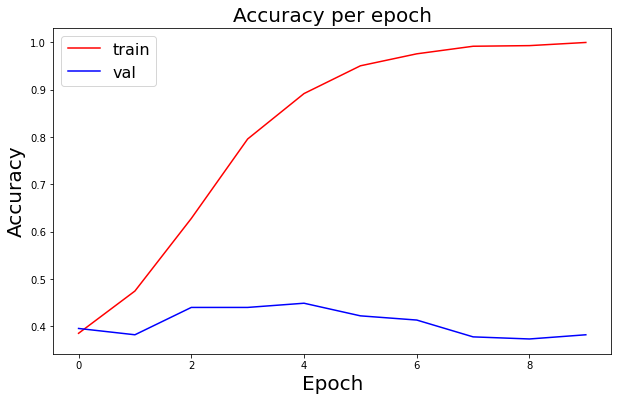

In [215]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(history_1.history['accuracy'], 'r', label='train')
ax.plot(history_1.history['val_accuracy'], 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
plt.title("Accuracy per epoch", fontsize = 20)
plt.legend(prop={'size': 16})
ax.tick_params(labelsize=10)
 

### Як видно, точність на виборці валідації значно нижча, ніж на тренувальній вибірці, отже наявний overfitting. Cпробуємо уникнути його, нормалізувавши дані.

### 1.2 Тренування з нормалізацією

In [216]:
train_datagen_norm = ImageDataGenerator(rescale = 1/255.)
test_datagen_norm = ImageDataGenerator(rescale = 1/255.)

# Setup the train and test directories
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

# Import data from directories and turn it into batches
train_data_norm = train_datagen_norm.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="categorical", # type of problem we're working on
                                               seed=42)

test_data_norm = test_datagen_norm.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

Found 750 images belonging to 3 classes.
Found 225 images belonging to 3 classes.


In [217]:
tf.random.set_seed(42)
history_1_norm = model_1.fit(train_data_norm,epochs=10,validation_data=test_data_norm)

Epoch 1/10
24/24 [==============================] - 6s 259ms/step - loss: 1.0756 - accuracy: 0.5160 - val_loss: 1.0947 - val_accuracy: 0.3422
Epoch 2/10
24/24 [==============================] - 6s 240ms/step - loss: 1.0540 - accuracy: 0.5013 - val_loss: 1.0844 - val_accuracy: 0.4000
Epoch 3/10
24/24 [==============================] - 6s 246ms/step - loss: 1.0291 - accuracy: 0.6147 - val_loss: 1.0794 - val_accuracy: 0.4267
Epoch 4/10
24/24 [==============================] - 6s 248ms/step - loss: 0.9976 - accuracy: 0.5893 - val_loss: 1.0566 - val_accuracy: 0.4622
Epoch 5/10
24/24 [==============================] - 6s 243ms/step - loss: 0.9254 - accuracy: 0.5867 - val_loss: 1.0272 - val_accuracy: 0.4667
Epoch 6/10
24/24 [==============================] - 6s 250ms/step - loss: 0.8237 - accuracy: 0.6507 - val_loss: 1.0537 - val_accuracy: 0.4578
Epoch 7/10
24/24 [==============================] - 6s 240ms/step - loss: 0.7512 - accuracy: 0.7133 - val_loss: 1.0768 - val_accuracy: 0.4667
Epoch 

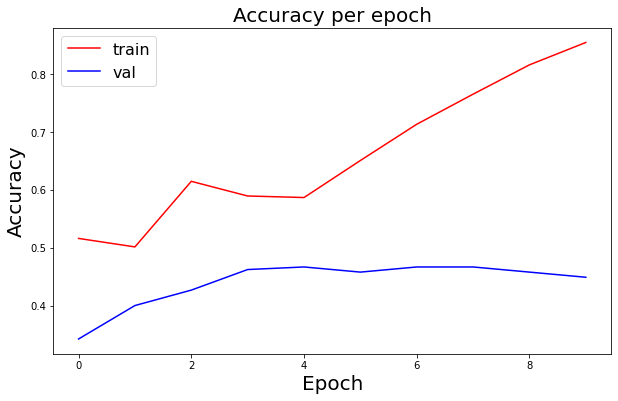

In [218]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(history_1_norm.history['accuracy'], 'r', label='train')
ax.plot(history_1_norm.history['val_accuracy'], 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
plt.title("Accuracy per epoch", fontsize = 20)
plt.legend(prop={'size': 16})
ax.tick_params(labelsize=10)

### Overfitting залишився, спробуємо використати data augmentation 

### 1.3 Модель з data augmentation 

In [219]:
train_datagen_norm_aug = ImageDataGenerator(rescale = 1/255., horizontal_flip = True,
                                   brightness_range = (0.2, 0.4), shear_range = 0.2, zoom_range = 0.2,  
                                   rotation_range = 0.3)

# Setup the train and test directories
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

# Import data from directories and turn it into batches
train_data_norm_aug = train_datagen_norm_aug.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="categorical", # type of problem we're working on
                                               seed=42)


Found 750 images belonging to 3 classes.


In [220]:
tf.random.set_seed(42)
first_model_time = time.time()
history_1_transform = model_1.fit(train_data_norm_aug,epochs=10,validation_data=test_data_norm)
time_1 = time.time() - first_model_time

Epoch 1/10
24/24 [==============================] - 14s 570ms/step - loss: 1.0680 - accuracy: 0.4800 - val_loss: 1.6636 - val_accuracy: 0.4489
Epoch 2/10
24/24 [==============================] - 13s 544ms/step - loss: 0.9493 - accuracy: 0.5547 - val_loss: 1.5011 - val_accuracy: 0.4622
Epoch 3/10
24/24 [==============================] - 13s 553ms/step - loss: 0.9163 - accuracy: 0.5800 - val_loss: 1.3273 - val_accuracy: 0.4933
Epoch 4/10
24/24 [==============================] - 14s 558ms/step - loss: 0.9442 - accuracy: 0.5480 - val_loss: 1.2929 - val_accuracy: 0.4800
Epoch 5/10
24/24 [==============================] - 13s 545ms/step - loss: 0.9692 - accuracy: 0.5333 - val_loss: 1.7695 - val_accuracy: 0.4578
Epoch 6/10
24/24 [==============================] - 13s 554ms/step - loss: 0.9506 - accuracy: 0.5547 - val_loss: 1.5220 - val_accuracy: 0.5022
Epoch 7/10
24/24 [==============================] - 13s 537ms/step - loss: 0.8927 - accuracy: 0.5667 - val_loss: 1.3697 - val_accuracy: 0.5244

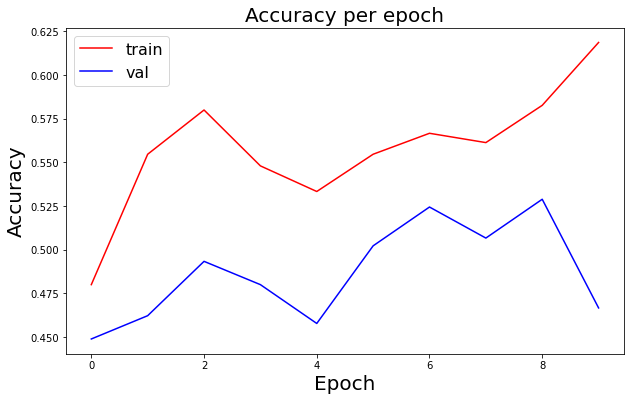

In [221]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(history_1_transform.history['accuracy'], 'r', label='train')
ax.plot(history_1_transform.history['val_accuracy'], 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
plt.title("Accuracy per epoch", fontsize = 20)
plt.legend(prop={'size': 16})
ax.tick_params(labelsize=10)

### Точність на виборці валідації зросла, проте на тренувальній вибірці стала гірше. Спробуємо тренування з більшою кількістю епох.

In [222]:
tf.random.set_seed(42)
history_2_transform = model_1.fit(train_data_norm_aug,epochs=20,validation_data=test_data_norm)

Epoch 1/20
24/24 [==============================] - 14s 565ms/step - loss: 0.8919 - accuracy: 0.5933 - val_loss: 1.5140 - val_accuracy: 0.5289
Epoch 2/20
24/24 [==============================] - 13s 543ms/step - loss: 0.8560 - accuracy: 0.5773 - val_loss: 1.4099 - val_accuracy: 0.5378
Epoch 3/20
24/24 [==============================] - 13s 542ms/step - loss: 0.8427 - accuracy: 0.6080 - val_loss: 1.5019 - val_accuracy: 0.4978
Epoch 4/20
24/24 [==============================] - 13s 543ms/step - loss: 0.8465 - accuracy: 0.5907 - val_loss: 1.5293 - val_accuracy: 0.4978
Epoch 5/20
24/24 [==============================] - 13s 551ms/step - loss: 0.8464 - accuracy: 0.6160 - val_loss: 1.4436 - val_accuracy: 0.5200
Epoch 6/20
24/24 [==============================] - 13s 555ms/step - loss: 0.8010 - accuracy: 0.6600 - val_loss: 1.4531 - val_accuracy: 0.5333
Epoch 7/20
24/24 [==============================] - 13s 547ms/step - loss: 0.8033 - accuracy: 0.6373 - val_loss: 1.5398 - val_accuracy: 0.5111

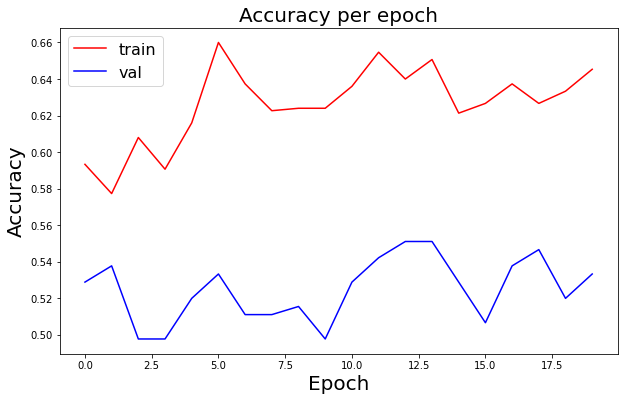

In [223]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(history_2_transform.history['accuracy'], 'r', label='train')
ax.plot(history_2_transform.history['val_accuracy'], 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
plt.title("Accuracy per epoch", fontsize = 20)
plt.legend(prop={'size': 16})
ax.tick_params(labelsize=10)

### Overfitting залишився

# 2.  Тренування спрощеної моделі з droupout

In [224]:
tf.random.set_seed(42)
model_drop = tf.keras.models.Sequential([
  Conv2D(filters=10, kernel_size=2, activation="relu", input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  MaxPool2D(2),
  Dropout(0.2),
  Flatten(),
  Dense(3, activation="softmax")])

# Compile the model
model_drop.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

tf.random.set_seed(42)
second_model_time = time.time()
history_drop = model_drop.fit(train_data_norm_aug,epochs=10,validation_data=test_data_norm)
time_2 = time.time() - second_model_time

Epoch 1/10
24/24 [==============================] - 13s 529ms/step - loss: 1.2811 - accuracy: 0.4253 - val_loss: 1.4346 - val_accuracy: 0.4844
Epoch 2/10
24/24 [==============================] - 12s 527ms/step - loss: 0.9528 - accuracy: 0.5480 - val_loss: 1.3702 - val_accuracy: 0.5289
Epoch 3/10
24/24 [==============================] - 13s 521ms/step - loss: 0.9179 - accuracy: 0.5667 - val_loss: 1.3327 - val_accuracy: 0.5200
Epoch 4/10
24/24 [==============================] - 13s 519ms/step - loss: 0.8936 - accuracy: 0.5907 - val_loss: 1.7202 - val_accuracy: 0.4844
Epoch 5/10
24/24 [==============================] - 13s 519ms/step - loss: 0.8927 - accuracy: 0.5907 - val_loss: 1.6383 - val_accuracy: 0.5200
Epoch 6/10
24/24 [==============================] - 12s 510ms/step - loss: 0.8671 - accuracy: 0.6053 - val_loss: 1.8856 - val_accuracy: 0.4889
Epoch 7/10
24/24 [==============================] - 13s 519ms/step - loss: 0.8388 - accuracy: 0.6187 - val_loss: 1.7086 - val_accuracy: 0.5467

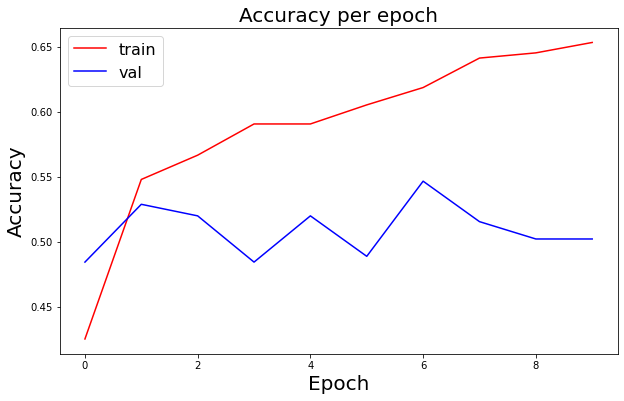

In [225]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(history_drop.history['accuracy'], 'r', label='train')
ax.plot(history_drop.history['val_accuracy'], 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
plt.title("Accuracy per epoch", fontsize = 20)
plt.legend(prop={'size': 16})
ax.tick_params(labelsize=10)

### Overfitting залишився.

# 3. Тренування мережі архітектури AlexNet

![alt text](AlexNet-1-1.png "Title")

In [226]:
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(224, 224, 3), kernel_size=(11,11), strides=(4,4), padding='same', activation="relu"))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same', activation="relu"))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation="relu"))
AlexNet.add(BatchNormalization())

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation="relu"))
AlexNet.add(BatchNormalization())

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation="relu"))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,),activation="relu"))
AlexNet.add(BatchNormalization())
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096,activation="relu"))
AlexNet.add(BatchNormalization())
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000,activation="relu"))
AlexNet.add(BatchNormalization())
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(3,activation="softmax")) 
AlexNet.add(BatchNormalization())

#Model Summary
AlexNet.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization_18 (Batc (None, 56, 56, 96)        384       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 28, 28, 256)       614656    
_________________________________________________________________
batch_normalization_19 (Batc (None, 28, 28, 256)       1024      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 14, 14, 384)     

In [227]:
tf.random.set_seed(42)
# Compile the model
AlexNet.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

third_model_time = time.time()
# Fit the model
history_alex = AlexNet.fit(train_data_norm_aug,epochs=10,validation_data=test_data_norm)
time_3 = time.time() - third_model_time

Epoch 1/10
24/24 [==============================] - 36s 1s/step - loss: 6.2636 - accuracy: 0.3293 - val_loss: 10.7454 - val_accuracy: 0.3333
Epoch 2/10
24/24 [==============================] - 33s 1s/step - loss: 5.3951 - accuracy: 0.3107 - val_loss: 10.6760 - val_accuracy: 0.3333
Epoch 3/10
24/24 [==============================] - 33s 1s/step - loss: 5.8048 - accuracy: 0.3467 - val_loss: 10.2639 - val_accuracy: 0.3467
Epoch 4/10
24/24 [==============================] - 33s 1s/step - loss: 6.0235 - accuracy: 0.3613 - val_loss: 10.7454 - val_accuracy: 0.3333
Epoch 5/10
24/24 [==============================] - 34s 1s/step - loss: 7.3089 - accuracy: 0.3560 - val_loss: 10.8170 - val_accuracy: 0.3289
Epoch 6/10
24/24 [==============================] - 33s 1s/step - loss: 7.4612 - accuracy: 0.3240 - val_loss: 10.7454 - val_accuracy: 0.3333
Epoch 7/10
24/24 [==============================] - 32s 1s/step - loss: 7.3574 - accuracy: 0.3280 - val_loss: 10.7454 - val_accuracy: 0.3333
Epoch 8/10
24

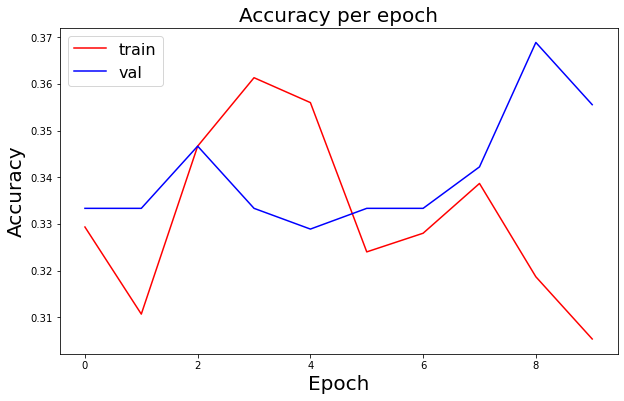

In [228]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(history_alex.history['accuracy'], 'r', label='train')
ax.plot(history_alex.history['val_accuracy'], 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
plt.title("Accuracy per epoch", fontsize = 20)
plt.legend(prop={'size': 16})
ax.tick_params(labelsize=10)

### Дана модель показала найгірші результати.

### Графік порівняня часу тренування трьох моделей

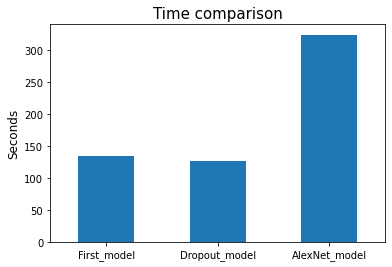

In [229]:
val = [time_1, time_2, time_3]

index = ['First_model', 'Dropout_model', 'AlexNet_model']

df = pd.DataFrame({'Seconds': val}, index=index)

ax = df.plot.bar(rot=0, legend = False)
plt.title("Time comparison",fontsize = 15)
plt.ylabel('Seconds', fontsize = 12)
plt.show()

# 4. Побудова прогнозу

### Прогноз за першою моделю

In [230]:
y_prob = model_1.predict(test_data_norm)
y_hat = y_prob.argmax(axis=1)
y_hat 

array([1, 2, 0, 1, 2, 0, 1, 1, 2, 1, 0, 0, 1, 0, 0, 1, 2, 1, 0, 2, 1, 2,
       2, 1, 0, 1, 2, 0, 0, 0, 1, 0, 1, 1, 0, 2, 1, 1, 2, 0, 0, 0, 2, 1,
       0, 1, 0, 2, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 1, 1, 1, 1, 2, 1, 2, 2,
       2, 0, 2, 2, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 2, 2, 2, 0, 1, 1,
       2, 2, 1, 1, 0, 2, 0, 1, 2, 0, 1, 2, 2, 0, 0, 0, 0, 0, 2, 2, 1, 1,
       2, 2, 2, 0, 0, 1, 0, 0, 1, 1, 0, 1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 0,
       2, 1, 1, 2, 0, 1, 2, 0, 0, 1, 2, 1, 2, 1, 1, 1, 2, 0, 1, 1, 0, 2,
       2, 1, 0, 1, 1, 0, 0, 2, 0, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 0, 0, 2,
       0, 0, 0, 0, 1, 0, 1, 2, 1, 1, 2, 1, 1, 0, 2, 0, 1, 0, 1, 1, 2, 0,
       2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 1, 0, 2,
       2, 0, 0, 0, 2], dtype=int64)

### Прогноз за другою моделю

In [231]:
y_prob = model_drop.predict(test_data_norm)
y_hat = y_prob.argmax(axis=1)
y_hat 

array([0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 0, 1, 0, 1, 1, 1,
       2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 2, 2, 0, 2, 1, 1,
       1, 0, 0, 2, 0, 1, 0, 0, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0,
       0, 2, 2, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 1, 2, 0, 0, 2, 0, 1, 0, 0, 1, 1, 2, 0, 2, 0, 1, 2,
       1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 2, 1, 0,
       1, 2, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       2, 0, 1, 1, 1, 2, 0, 0, 2, 0, 2, 1, 1, 0, 2, 1, 0, 2, 1, 0, 0, 0,
       0, 2, 2, 1, 2], dtype=int64)

### Прогноз за третьою моделю

In [232]:
y_prob = AlexNet.predict(test_data_norm)
y_hat = y_prob.argmax(axis=1)
y_hat 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1], dtype=int64)

In [233]:
def load_and_prep_image(filename, img_shape=224):
    img = tf.io.read_file(filename)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, size = [img_shape, img_shape])
    img = img/255.
    return img

In [234]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
    if len(pred[0]) > 1:  
        pred_class = class_names[pred.argmax()] 
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

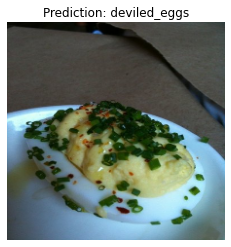

In [235]:
pred_and_plot(model_1, "C:\\Users\\Mitya\\Desktop\\Нейронні мережі\\Lab4\\101_food_classes_10_percent\\test\\deviled_eggs\\32282.jpg", class_names)

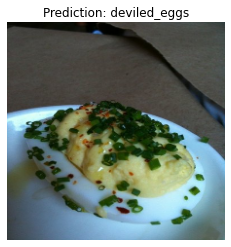

In [236]:
pred_and_plot(model_drop, "C:\\Users\\Mitya\\Desktop\\Нейронні мережі\\Lab4\\101_food_classes_10_percent\\test\\deviled_eggs\\32282.jpg", class_names)

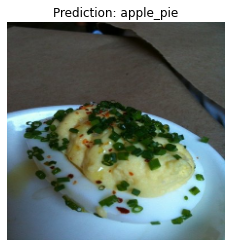

In [237]:
pred_and_plot(AlexNet, "C:\\Users\\Mitya\\Desktop\\Нейронні мережі\\Lab4\\101_food_classes_10_percent\\test\\deviled_eggs\\32282.jpg", class_names)

# Висновки:
В результаті виконання даної лабораторної була проведена класифікація за домомогою згорткових нейронних мереж. В усіх моделях було наявне перенавчання, що не дало змогу зробити якісний прогноз.